In [89]:
import pandas as pd
import numpy as np
import re
import plotly.graph_objects as go
from sklearn.metrics import r2_score

<Axes: >

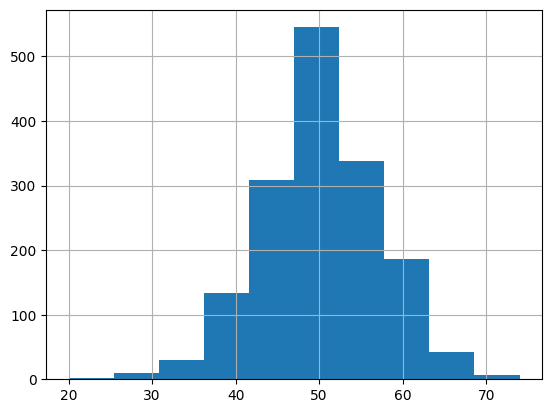

In [90]:
oes_df = pd.read_excel("MSA_M2019_dl.xlsx")
oes_df = oes_df[oes_df["o_group"] == "major"]
oes_df = oes_df[["area_title", "occ_title", "occ_code", "a_mean"]].drop_duplicates()
resid_df = pd.read_pickle("Run1_2019.pkl")
display(resid_df["n_ads"].hist())
resid_df = resid_df[resid_df["id"].map(lambda x: "soc" in x)]
resid_df = resid_df[["city_state", "id", "loc_mean_salary"]]

In [91]:
def clean_loc(text): 
    text = " ".join(text.split(" ")[:-1])
    text = text.replace("-", " ")
    text = re.sub(r"[^a-zA-Z0-9 ]", "", text)
    return text.lower().strip()

def city_map(val, vals):

    for v in vals:
        if val in v:
            return v

resid_df["clean_loc"] = resid_df["city_state"].map(clean_loc)
oes_df["clean_loc"] = oes_df["area_title"].map(clean_loc)

oes_df["map_loc"] = oes_df["clean_loc"]
resid_df["map_loc"] = resid_df["clean_loc"].map(lambda x: city_map(x, oes_df["clean_loc"].unique()))

resid_df["soc_code"] = resid_df["id"].map(lambda x: int(x.split("_")[1]))
oes_df["soc_code"] = oes_df["occ_code"].map(lambda x: int(x.split("-")[0]))

resid_df = resid_df[resid_df["map_loc"].notnull()]
oes_df = oes_df[oes_df["map_loc"].notnull()]

display(resid_df.head())
display(oes_df.head())

,city_state,id,loc_mean_salary,clean_loc,map_loc,soc_code
0,new york NY,soc_43,49468.0,new york,new york newark jersey city,43
1,los angeles CA,soc_43,48248.0,los angeles,los angeles long beach anaheim,43
2,houston TX,soc_43,40935.0,houston,houston the woodlands sugar land,43
3,chicago IL,soc_43,51436.0,chicago,chicago naperville elgin,43
4,dallas TX,soc_43,46309.0,dallas,dallas fort worth arlington,43


,area_title,occ_title,occ_code,a_mean,clean_loc,map_loc,soc_code
1,"Abilene, TX",Management Occupations,11-0000,90500,abilene,abilene,11
18,"Abilene, TX",Business and Financial Operations Occupations,13-0000,67520,abilene,abilene,13
36,"Abilene, TX",Computer and Mathematical Occupations,15-0000,62970,abilene,abilene,15
44,"Abilene, TX",Architecture and Engineering Occupations,17-0000,72440,abilene,abilene,17
54,"Abilene, TX","Life, Physical, and Social Science Occupations",19-0000,58360,abilene,abilene,19


In [92]:
print("OES MSA by Occ Pairs: ", len(oes_df))
print("Resid City by Occ Pairs: ", len(resid_df))

OES MSA by Occ Pairs:  8645
Resid City by Occ Pairs:  710


In [93]:
cmb_df = resid_df.merge(
    oes_df,
    on = ["map_loc", "soc_code"],
    how="left",
)

In [ ]:
cmb_df2 = cmb_df.groupby(["map_loc", "soc_code", "occ_title"]).agg({"loc_mean_salary": "mean", "a_mean": "mean"}).reset_index()
cmb_df2["occ_title"] = cmb_df2["occ_title"].map(lambda x: " ".join(x.split(" ")[:-1]))
cmb_df2.rename(columns={"loc_mean_salary": "residuals", "a_mean": "oes_est"}, inplace=True)

# plot plotly scatter plot of residuals vs OES estimates colored by discrete occ_title with labeled legend, log both axes
fig = go.Figure()
for occ in cmb_df2["occ_title"].unique():
    fig.add_trace(
        go.Scatter(
            x = cmb_df2[cmb_df2["occ_title"] == occ]["oes_est"],
            y = cmb_df2[cmb_df2["occ_title"] == occ]["residuals"],
            mode = "markers",
            name = occ,
            marker=dict(size=5),
        )
    )
fig.update_layout(
    title="Residuals vs OES Estimates by MSA-Occupation",
    xaxis_title="OES Estimates",
    yaxis_title="Residuals",
    legend_title_text="Occupation",
    width=800,
    height=600,
    # set xaxis and yaxis range
    xaxis_range=[15_000, 150_000],
    yaxis_range=[15_000, 150_000],
)
fig.update_traces(marker=dict(line=dict(width=1, color='DarkSlateGrey')))

# equality line when residuals = OES estimates
x = np.linspace(15_000, 150_000, 100)
y = x
fig.add_trace(
    go.Scatter(
        x=x,
        y=y,
        mode="lines",
        name="Equality Line",
        line=dict(color="red", width=2),
    )
)
# add r2

r2 = r2_score(cmb_df2["oes_est"], cmb_df2["residuals"])
fig.add_annotation(
    x=0.5,
    y=0.9,
    xref="paper",
    yref="paper",
    text=f"R² = {r2:.2f}",
    showarrow=False,
    font=dict(size=16),
)

# add text to the points with the occ_title
fig.show()
